# 4.1 Corner detection and description

Keypoint detection is the searching of *interesting* pixels (or points) in images (sometimes also referred as *image features*). There exist different types of keypoints e.g. corners, blobs, edges, ridges, etc. each of them with different properties, but, in this notebook, we will focus just on corner detection. In this context, a *corner* is an image point with high variation of intensity in two spatial directions.

Concretely, this notebook is covering corner detection using the well-known and widely used **Harris corner detector**. It is important to remark that the output of such detector are just the **positions** of the corners in the images (that's the purpose of a *detector*, actually). So, in order to be able to distinguish between different corners, we have to incorporate some kind of information about the **appearance** of the keypoint, which will be useful to match corresponding corners in different images. This is called the **description** of the corner. In this sense, we are going to explore how to use a patch around the keypoint as the descriptor, and employ the so-called **Normalized Cross-Correlation** (NCC) to find such matches.

## Problem context - Image stitching

Image stitching or photo stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image:

<img src="./images/stitching.jpg" width="600">

Feature detection is necessary to find correspondences between images. Robust correspondences are required in order to estimate the necessary transformation to align an image with the image it is being composited on. 

Our task in this notebook is to develop the first step in this process. This lies in developing a robust point matching between overlapping images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Before starting to work, you will have to complete some explained exercises in order to familiarize with the Harris corner detector.

As usual, **display testing image** `car.jpeg` in the RGB color space. Remember that by default OpenCV reads the image in BGR mode, so you'll have to convert it.

In [2]:
# Read 'car.jpeg' image, convert to RGB and display it
# Write your code here!

### Harris corner detector

First, let's remind how the Harris method works:

The main idea is to construct a matrix $\mathbf{M}$ that differences between pixels that are corners and pixels that are not. As seen in the course lessons, this can be done combining image derivatives (e.g. Sobel) and Gaussian smoothing:

$$\mathbf{M} = \begin{bmatrix}
\sum_{W} g\oplus I_x^2 & \sum_{W}{g\oplus(I_x I_y)}\\
\sum_{W}{g\oplus(I_xI_y)} & \sum_{W}{g\oplus(I_y^2)}
\end{bmatrix}$$

Being $W$ a window around the pixel, $I_x$ and $I_y$ the image derivatives, and $g$ the Gaussian kernel. $\\[10pt]$

<img src="./images/harris.png" width="600">$\\[5pt]$

Then, to detect the corners, the $R$ value is calculated for each pixel as follows:

$$R = \texttt{det} \mathbf{M} - k (\texttt{trace} \mathbf{M})^2$$

so that:
- $R$ is large and positive at corners
- $R$ is negative at edges
- $R$ is small at flat regions 

**NOTE:** *The complete math derivation for this matrix can be found in the slides for chapter 3.* $\\[10pt]$


In practice, the Harris detector is already implemented in openCV in [cv2.cornerHarris](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris), taking as inputs:


- **src**: input grayscale image
- **block_size**: size of Gaussian window
- **ksize**: size of the sobel filter used (and odd value)
- **k**: empiric constant (usually 0.04 - 0.06)

**<span style="color:red">EXERCISE 4.1.1 -- </span>** Calculate the $R$ matrix of the previous image using the Harris detector and display it.

In [3]:
# EXERCISE 4.1.1
# Compute the R matrix of the previous image and display it
# Write your code here!

In the $R$ matrix, you should see an image where borders are black, corners are white and flat surfaces are gray.

**You have to** play with input parameters and **answer following questions**:

- What happens if $W$ size is 1?
- What happens if $W$ is large? (*note that `cv2.cornerHarris` uses neighborhood averaging instead of Gaussian*)

**<span style="color:blue">(Answer these questions here!)</span>**

Next, **you will have to** find pixels where $R$ is high (i.e. $R >$ threshold).  
But... what are the maximum and minimum values in $R$ image? Print them.

In [4]:
# Print max and min values of the R matrix (given)
print("Max: " , R.max(), "\nMin: ", R.min())

Are those values the same for different images or input parameters?  

**No**, they are not. As they change, it is necessary to define the threshold over the maximum value in image (in this way we skip normalization).  

**<span style="color:red">EXERCISE 4.1.2 -- </span>** Display the binarized image using a threshold that you think is suitable.

In [5]:
# EXERCISE 4.1.2
# Define the threshold wrt the maximum value, apply binarization to the image and display the result
# Write your code here!

As we are looking for points, this binarized image is not completely valid because it has many responses for the same point. A solution is to apply **non-maximum suppression** to those clusters of points, keeping only a point for each of them (remember that this step was also part of the Canny edge detector!).$\\[10pt]$

<img src="./images/nonmax.png" width="600">$\\[5pt]$

To simplify this, we provide you a `nonmaxsuppts` function with an implementation of the non-max suppression step, which finds local maxima as corners within a window.

In [6]:
# This method has been provided to you
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

In order to represent keypoints, OpenCV defines a set of functions for drawing objects related to feature detection. An example is [cv2.drawKeypoints](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433), which given an image and a list of [cv2.KeyPoint](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) objects, it draws them on the output image (third input argument).

Note that this implies the transformation of `r` and `c` to a `cv2.KeyPoint` list. *Have a look to: [rows and columns to KeyPoint list ideas](https://www.programcreek.com/python/example/77058/cv2.KeyPoint)*

**<span style="color:red">EXERCISE 4.1.3 -- </span>** Apply non-maxima suppression to the previous $R$ image and draw the detected keypoints on the image.

In [7]:
# EXERCISE 4.1.3
# Apply non-max suppression to R and display the remaining keypoints on the image
# Write your code here!

### Keypoint description through NCC

One important thing to understand is that after extracting the keypoints, you only obtain information about their position. While the information about keypoint position might sometimes be useful, it does not say much about the keypoints themselves. Usually you need to know how different or similar the keypoints are.

This is where computing the **Normalized Cross-Correlation** (NCC) appears: a way to determine how similar are two keypoints. Computing the NCC is similar to applying a convolution, i.e. a sliding window (the template or kernel) is operated over an image. The difference between NCC  and the convolution is that in NCC the kernel is not flipped. The N in NCC means that the results are normalized in order to being invariant to changes in brightness and constrast.$\\[5pt]$

<img src="./images/ncc_convolution.jpg" width="400">$\\[5pt]$

OpenCV implements the function [cv2.matchTemplate](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html?highlight=matchtemplate)(image, template, cv2.TM_CCORR_NORMED), to compute the NCC of `template` over `image`.

This code will help you to understand how NCC works.   
- **Review it and try to explain what is done here** (you can modify `p_index` and `w_temp` parameters).

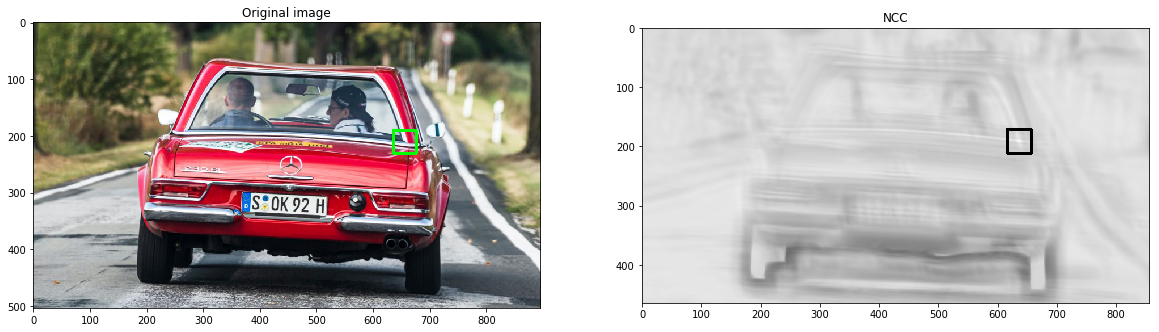

In [25]:
# This snippet has been provided to you. Play with 'p_index' and 'w_temp' values

# Index of the focusing point
p_index = 26

# NCC window aperture
w_temp = 20

# Get the NCC window
p_r, p_c = r[p_index], c[p_index]
template = image[p_r-w_temp:p_r+w_temp+1,p_c-w_temp:p_c+w_temp+1]

# Calculate the NCC image (note the cv2.TM_CCORR_NORMED parameter!)
ncc = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)

# Search the maximum in NCC
p_x, p_y = p_c, p_r
[max_y, max_x] = np.where(ncc == np.amax(ncc))

# Draw a rectangle in matching points
image_draw = np.copy(image)
ncc_draw = np.copy(ncc)

cv2.rectangle(image_draw,(p_x-w_temp,p_y-w_temp),(p_x+w_temp+1,p_y+w_temp+1),(0,255,0),3)
cv2.rectangle(ncc_draw,(max_x-w_temp,max_y-w_temp),(max_x+w_temp+1,max_y+w_temp+1),0,3)

# Show the original image
plt.subplot(121)
plt.imshow(image_draw)
plt.title('Original image')

# Show the NCC image
plt.subplot(122)
plt.imshow(ncc_draw, cmap='gray')
plt.title('NCC')
plt.show()

Now, **answer following questions**:

- Describe the variables `p_index` and `w_temp`
- What does the NCC image represent?
- What would happen if `template` was taken from a similar (but not the same) image?

**<span style="color:blue">(Answer these questions here!)</span>**

# Time to work! Find matches between images with (some) overlapping

It is time to apply what have been learnt during this notebook. Coming back to image stitching, **you are asked** to compute matches between two images with overlapping fields. The images are `park_l.jpeg` (left) and `park_r.jpeg` (right).

**You are asked to use the Harris corner detector and the NCC descriptor**. Also, you will have to draw the keypoints and the matches using [cv2.drawMatches](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1), which takes two images, two lists of `cv2.KeyPoint` objects and a list of [cv2.DMatch](https://docs.opencv.org/3.4/d4/de0/classcv_1_1DMatch.html) objects as input. To create a `cv2.DMatch` object it is used `cv2.DMatch(idx_l, idx_r,1)`, being `idx_l` and `idx_r` the indices of the keypoints being matched.

*Tip: [Drawing functions documentation](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html)* 

Results should look like this (output of `cv2.drawMatches`):

<img src="./images/index.png" width="1000">

Now it's your turn:  
**<span style="color:red">EXERCISE 4.1.4a -- </span>**
- Use the Harris corner detector to get the keypoints of both images (do not forget to apply non-max suppression!)
- Convert them to two lists of `cv2.KeyPoint` objects

In [8]:
# EXERCISE 4.1.4a
# Detect Harris keypoints in the images and convert them to a 'cv2.Keypoint' list
# Write your code here!

**<span style="color:red">EXERCISE 4.1.4b -- </span>**
Now, in order to ensure that the window for getting the patch is not going to access out of image limits (e.g. keypoint at (0,0)), add padding to images using  the function
[cv2.copyMakeBorder](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=copymakeborder#void%20copyMakeBorder(InputArray%20src,%20OutputArray%20dst,%20int%20top,%20int%20bottom,%20int%20left,%20int%20right,%20int%20borderType,%20const%20Scalar&%20value)) (`cv2.BORDER_REFLECT` is the best padding option in this case)

In [9]:
# EXERCISE 4.1.4b
# Add padding to the images
# Write your code here!

**<span style="color:red">EXERCISE 4.1.4c -- </span>**

And finally:
- For each keypoint in the left image.
    - Take a template over that point.
    - Compute the NCC value using that template over the whole right image.
    - If there is a NCC value grater than 0.95 (tune this threshold for robustness) define the matching keypoint in right image and create a `cv2.DMatch` object.
- Once all matches are defined, call `cv2.drawMatches` and display the resulting image.

Be careful with the number of keypoints detected, as it could take a time to process all of them.

In [10]:
# EXERCISE 4.1.4c
# Match the keypoints in both images by using NCC, get a 'cv2.DMatch' list and display the matches
# Write your code here!

# Back to the 21st century! Using FAST and ORB

The Harris corner detector has been employed in a vast amount of works since its proposal back in 1988 and it's still being used in many approaches because of its simplicity and performance. However, the computer vision community has obviously moved on in recent years and nowadays is being focused in using faster methods to detect corners. One of the most successful and popular methods for detecting corners is called **FAST** (**F**eatures from **A**ccelerated **S**egment **T**est), which, has its name suggest is clearly faster than most of the methods developed so far. [Published in 2006](https://link.springer.com/chapter/10.1007/11744023_34), the work by Rosten and Drummond claims to operate around 20x faster than the Harris method and finds a considerably large amount of keypoints (sometimes too much!).

In a nutshell, in its original form, it operates by comparing the grey level of certain pixel in the image with its surrounding pixels in a circle of 16 pixels. If at least 12 consecutive pixels in that circle are brighter (or less bright) than the candidate, then it is a considered as a corner. 

<img src="./images/fast.png" width="500">

In fact, by wisely picking up the first 4 pixels to compare, fast rejection of candidates can be easily applied. Some variations of the original proposal have been developed later, turning the FAST-based approaches a prominent method for detecting corners nowadays.

However, this method **does not provide a descriptor** for the detected corners, so, as we learnt before, they must be augmented with a descriptor in order to be matched! In this case we are going to explore the ORB method, which is [a detection and description method](https://ieeexplore.ieee.org/abstract/document/6126544) developed in 2011 by Rublee *et.al*.

ORB stands for **O**riented FAST and **R**otated **B**RIEF and combines the FAST detector with a modified version of the [BRIEF descriptor](https://link.springer.com/chapter/10.1007/978-3-642-15561-1_56). In short, it detects FAST corners and computes its main orientation. Then it rotates the sourrounding patch of the keypoint according to the main orientation and computes the BRIEF descriptor in it. The BRIEF descriptor is computed by comparing the grey level in a set of pixels within the (rotated) patch, yielding a binary sequence that corresponds to the descriptor. Being binary descriptors, they can be easily compared by using the so-called [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance), which, essentially, computes the number of different bits in the two descriptors.

**<span style="color:red">EXERCISE 4.1.5 -- </span>**

Now let's try a simple example of using ORB. Write a script that:
- Loads the two previous sample images in grayscale.
- Detect ORB keypoints.
- Compute their ORB descriptor.
- Use a Brute-Force matcher to find correspondences between both sets of keypoints and order them according to distance (have a look to [`sorted()`](https://wiki.python.org/moin/HowTo/Sorting) and use as key the lambda function `x:x.distance`). Set the `crossCheck` argument to `True`.
- Once all matches are defined, call `cv2.drawMatches` and display the resulting image with the 30 best matches. Try `cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS` as flag in this function call.

Tips: Search for some documentation regarding ORB detection/description and brute-force matching in OpenCV.

In [11]:
# EXERCISE 4.1.5
# Detect and describe keypoints using ORB in two images ('park_l.jpeg' and 'park_r.jpeg'), then match them using a brute-force matcher.
# Write your code here

## Conclusion

This was a hard work, but finally you made it! In this notebook you have learnt to:

- detect corners using the Harris detector.
- match corners using NCC.
- develop the first steps for an image stitching system.
- use state-of-the-art detectors and descriptors as FAST and ORB.